In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 'drive/MyDrive/Spotify feature classification/Code/Data and Weights'

 2DSpec_wBest1.hdf5	        CSE190_proj_data.ipynb
 2DSpec_wBest.hdf5	       'CSE190_spectrogram data.ipynb'
 2DSpec_wCurrent1.h5	        JaarSongs
 2DSpec_wCurrent.h5	        L_array_44100.pkl
 2DSpec_wCurrent_noDropout.h5   mono_mfcc_normedz_44100.pkl
 3DSpec_wBest.hdf5	        MS_mfcc_normedz_44100.pkl
 3DSpec_wCurrent1.h5	        X_array_22050.pkl
 3DSpec_wCurrent.h5


In [ ]:
import shutil

file_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/MS_mfcc_normedz_44100.pkl'
destination_path = '../content/sample_data/'
shutil.copyfile(file_path, destination_path + 'MS_mfcc_normedz_44100.pkl')

file_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/L_array_44100.pkl'
destination_path = '../content/sample_data/'
shutil.copyfile(file_path, destination_path + 'L_array_44100.pkl')

'../content/sample_data/L_array_44100.pkl'

In [ ]:
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from numpy.random import choice
from collections import OrderedDict

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Concatenate, Activation, Lambda
from keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, AveragePooling3D
from keras.optimizers import SGD, Adam
# from keras.layers import LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

2.12.0


In [ ]:
with open('sample_data/MS_mfcc_normedz_44100.pkl', 'rb') as file:
    X = pickle.load(file)
with open('sample_data/L_array_44100.pkl', 'rb') as file:
    labels = pickle.load(file)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=77)
# X = np.transpose(X, (0,2,3,1))
X_train = np.transpose(X_train, (0,2,3,1))
X_test = np.transpose(X_test, (0,2,3,1))

X_train_3D = np.reshape(X_train, (520, 24, 68, 38, 2))
X_test_3D = np.reshape(X_test, (130, 24, 68, 38, 2))

X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_3D.shape, X_test_3D.shape

((520, 24, 2584, 2),
 (130, 24, 2584, 2),
 (520,),
 (130,),
 (520, 24, 68, 38, 2),
 (130, 24, 68, 38, 2))

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Convolutional network deffinition
#### The output is not a classifier and instead a numeric value

In [ ]:
### 3D SPECTROGRAM PARALLEL CONVOLUTION MODEL

def create_model_3D_MFCC(resize_shape):
    # resize_shape = 24, 68, 38, 2
    # factors are 2,2,2,3 and 2,2,17 and 2,19
    # Mid and side inputs
    input_MS = Input(shape = resize_shape)

    # Convolutional layers for sequence 1
    conv = Conv3D(64, (3, 2, 2), activation='relu', kernel_initializer='he_normal')(input_MS)
    conv = Conv3D(128, (3, 2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    conv = AveragePooling3D((2, 2, 2))(conv)
    conv = Conv3D(128, (3, 2, 3), activation='relu', kernel_initializer='he_normal')(conv)
    conv = Conv3D(256, (2, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    conv = MaxPooling3D((1, 2, 2))(conv)
    conv = Conv3D(256, (2, 2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    conv = Conv3D(512, (2, 2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    #conv = AveragePooling3D((1, 2, 2))(conv)
    conv = Flatten()(conv)
    #conv = Dropout(0.3)(conv)

    # Concatenate the representations of both sequences
    # combined = Concatenate()([conv_mid, conv_side])

    # Fully connected -> output
    combined = Dense(256, activation='relu')(conv)
    combined = BatchNorm()(combined)
    combined = Dense(64)(combined)
    combined = Dropout(0.3)(combined)
    combined = BatchNorm()(combined)
    combined = Dense(16, activation='relu')(combined)
    combined = BatchNorm()(combined)
    prediction = Dense(1, activation='sigmoid')(combined)

    # Create the model with two inputs and one output
    model = Model(inputs=input_MS, outputs=prediction)

    return model

# Create model
# Shape is one (24, 68, 38) or one 30 sec window stacked in 38ths
# factors are 2,2,2,3 and 2,2,17 and 2,19
model_3D_spec = create_model_3D_MFCC((24, 68, 38, 2))

# Compile the model for regression
opt = Adam(learning_rate=0.01)
model_3D_spec.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
model_3D_spec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 68, 38, 2)]   0         
                                                                 
 conv3d (Conv3D)             (None, 22, 67, 37, 64)    1600      
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 66, 36, 128)   98432     
                                                                 
 dropout (Dropout)           (None, 20, 66, 36, 128)   0         
                                                                 
 batch_normalization (BatchN  (None, 20, 66, 36, 128)  512       
 ormalization)                                                   
                                                                 
 average_pooling3d (AverageP  (None, 10, 33, 18, 128)  0         
 ooling3D)                                                   

In [ ]:
#X_test_3D

# Train the model

In [ ]:
def train_network(model):
    checkpoint = ModelCheckpoint(
        "3DSpec_wBest.hdf5",
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    callbacks_list = [checkpoint]
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

    hist = model.fit(x=X_train_3D, y=y_train, batch_size=4, epochs=150, shuffle=True, validation_data = (X_test_3D, y_test), callbacks = callbacks_list)
    model.save_weights('drive/MyDrive/Spotify feature classification/Code/Data and Weights/3DSpec_wCurrent.h5')
    model.save_weights('3DSpec_wCurrent.h5')

    file_path = '3DSpec_wBest.hdf5'
    destination_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/'
    shutil.copyfile(file_path, destination_path + '3DSpec_wBest.hdf5')

    return hist

history = train_network(model_3D_spec)

Epoch 1/150
130/130 [==============================] - ETA: 0s - loss: 0.1996 - mean_absolute_error: 0.1996
Epoch 1: val_loss improved from inf to 0.25857, saving model to 3DSpec_wBest.hdf5
130/130 [==============================] - 71s 431ms/step - loss: 0.1996 - mean_absolute_error: 0.1996 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586
Epoch 2/150
130/130 [==============================] - ETA: 0s - loss: 0.1725 - mean_absolute_error: 0.1725
Epoch 2: val_loss improved from 0.25857 to 0.20780, saving model to 3DSpec_wBest.hdf5
130/130 [==============================] - 31s 240ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.2078 - val_mean_absolute_error: 0.2078
Epoch 3/150
130/130 [==============================] - ETA: 0s - loss: 0.1694 - mean_absolute_error: 0.1694
Epoch 3: val_loss did not improve from 0.20780
130/130 [==============================] - 18s 140ms/step - loss: 0.1694 - mean_absolute_error: 0.1694 - val_loss: 0.2174 - val_mean_absolute_error: 

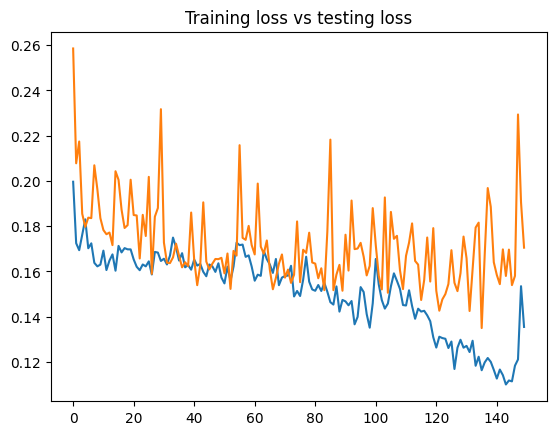

In [ ]:
plt.title("Training loss vs testing loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

It can be observed that as the model continues to overfit the training data, the validation loss jumps up and down in-between epochs.  This indicates that generalization is not necessarily getting better, and is akin to the model taking shots in the dark at testing improvements after only a few epochs.

# Test the model and plot results

In [ ]:
model_3D_spec = create_model_3D_MFCC((24, 68, 38, 2))
model_3D_spec.load_weights('drive/MyDrive/Spotify feature classification/Code/Data and Weights/3DSpec_wCurrent.h5')

def correlation_coefficient(X, Y):
    # Check if both arrays have the same length
    if len(X) != len(Y):
        raise ValueError("Both arrays must have the same length.")

    n = len(X)

    # Calculate the means of both arrays
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)

    # Calculate the numerator of the correlation coefficient
    numerator = np.sum((X - mean_X) * (Y - mean_Y))

    # Calculate the denominator of the correlation coefficient
    denominator = np.sqrt(np.sum((X - mean_X)**2) * np.sum((Y - mean_Y)**2))

    # Calculate the correlation coefficient (r)
    r = numerator / denominator

    return r

In [ ]:
### MEAN ERRORS of train and test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_pred = model_3D_spec.predict(X_train_3D[:])
test_pred = model_3D_spec.predict(X_test_3D[:])

train_error = np.sum(np.abs(train_pred - y_train))/len(y_train)
test_error = np.sum(np.abs(test_pred - y_test))/len(y_test)
print("Average training error (absolute):", train_error)
print("Average testing error (absolute):", test_error)
print()
print("Standard deviation of train error:", np.sqrt(np.sum(np.abs(np.abs(train_pred - y_train)-train_error))/len(y_train)))
print("Standard deviation of test error:", np.sqrt(np.sum(np.abs(np.abs(test_pred - y_test)-test_error))/len(y_test)))

train_error = np.sum(np.square(train_pred - y_train))/len(y_train)
test_error = np.sum(np.square(test_pred - y_test))/len(y_test)
print("Average training error (square):", train_error)
print("Average testing error (square):", test_error)
### How many predicitons are significantly off
print()
print(len(y_train[np.abs(train_pred - y_train) > 0.2]) / len(y_train))
print(len(y_test[np.abs(test_pred - y_test) > 0.2]) / len(y_test))
print()
result = correlation_coefficient(train_pred, y_train.reshape(-1, 1))
print("Correlation coefficient train:", result)
result = correlation_coefficient(test_pred, y_test.reshape(-1, 1))
print("Correlation coefficient test:", result)

5/5 [==============================] - 1s 252ms/step
Average training error (absolute): 0.12960219342383197
Average testing error (absolute): 0.17048920756233998

Standard deviation of train error: 0.2814122966821741
Standard deviation of test error: 0.3052052265829598
Average training error (square): 0.026651923076627088
Average testing error (square): 0.04124417752426693

0.2230769230769231
0.4

Correlation coefficient train: 0.7059685447082794
Correlation coefficient test: 0.41481939887478597


### And now, as we look at the correlation, we see that the testing predictions are actually significantly less correlated.

In [ ]:
model_3D_spec.load_weights("drive/MyDrive/Spotify feature classification/Code/Data and Weights/3DSpec_wBest.hdf5")

### MEAN ERRORS of train and test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_pred = model_3D_spec.predict(X_train_3D[:])
test_pred = model_3D_spec.predict(X_test_3D[:])
print()
train_error = np.sum(np.abs(train_pred - y_train))/len(y_train)
test_error = np.sum(np.abs(test_pred - y_test))/len(y_test)
print("Average training error (absolute):", train_error)
print("Average testing error (absolute):", test_error)
print()
print("Standard deviation of train error:", np.sqrt(np.sum(np.abs(np.abs(train_pred - y_train)-train_error))/len(y_train)))
print("Standard deviation of test error:", np.sqrt(np.sum(np.abs(np.abs(test_pred - y_test)-test_error))/len(y_test)))

train_error = np.sum(np.square(train_pred - y_train))/len(y_train)
test_error = np.sum(np.square(test_pred - y_test))/len(y_test)
print("Average training error (square):", train_error)
print("Average testing error (square):", test_error)
print()
print(len(y_train[np.abs(train_pred - y_train) > 0.2]) / len(y_train), "% training are significantly off.")
print(len(y_test[np.abs(test_pred - y_test) > 0.2]) / len(y_test), "% testing are significantly off.")
print()
result = correlation_coefficient(train_pred, y_train.reshape(-1, 1))
print("Correlation coefficient train:", result)
result = correlation_coefficient(test_pred, y_test.reshape(-1, 1))
print("Correlation coefficient test:", result)

5/5 [==============================] - 1s 255ms/step

Average training error (absolute): 0.1043600738051763
Average testing error (absolute): 0.13493944927949172

Standard deviation of train error: 0.27080713995018096
Standard deviation of test error: 0.2986572152499975
Average training error (square): 0.021127691218497315
Average testing error (square): 0.029486467379856857

0.15576923076923077 % training are significantly off.
0.2846153846153846 % testing are significantly off.

Correlation coefficient train: 0.7323040344515178
Correlation coefficient test: 0.5712053393437725


In [ ]:
# I wish to try a parallel convolutional network... one where I take convolved mid info and convolved side info,
# and then concatenate them into more linear layers towards the end

# Actually, it might actually be interesting + worth trying stacking the input on top of itself... perhaps in time
# with the songs bpm or measures... that way, what is happenning can also be convolved with events further in the future

In [ ]:
# Testing accuracy can be measured a number of ways here.  Could be percentage, where wrong is certain distance from correct answer.
# Or just percentage based on overall distance from ground truth.  Or just loss.  Or some other arbitrary labelling method.